# Preprocessing des Données pour le Modèle Entraîné

Ce notebook prépare les données brutes avant l'utilisation du modèle supervisé.

**Étapes:**
1. Chargement des données brutes
2. **Visualisation des données brutes** (distribution de alert_flag, variables numériques)
3. Feature Engineering Patient-Centric
4. **Visualisation des features créées** (delta, z-score, catégorielles)
5. Vérification et validation des features
6. Sauvegarde des données préprocessées (optionnel)
7. Préparation pour l'utilisation avec le modèle

**Modèle**: HistGradientBoostingClassifier (accuracy calibrée via `--target-accuracy`, ex. **≈95%**)


## 1. Imports et Configuration


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

# Masquer les warnings non critiques
warnings.filterwarnings('ignore', category=UserWarning, module='joblib')

# Configuration du style pour les visualisations
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

# Configuration
data_path = "../data/clinical_alerts.csv"
output_path = "../data/clinical_alerts_preprocessed.csv"  # Optionnel
window = 7  # Taille de la fenêtre glissante en jours

print("="*70)
print("PREPROCESSING DES DONNEES POUR LE MODELE ENTRAINE")
print("="*70)
print(f"\nDonnées brutes: {data_path}")
print(f"Fenêtre glissante: {window} jours")
print("\n✅ Configuration terminée!")


PREPROCESSING DES DONNEES POUR LE MODELE ENTRAINE

Données brutes: ../data/clinical_alerts.csv
Fenêtre glissante: 7 jours

✅ Configuration terminée!


In [2]:
# Charger les données
df_raw = pd.read_csv(data_path)

print("="*70)
print("CHARGEMENT DES DONNEES")
print("="*70)
print(f"\n✅ Données chargées: {len(df_raw)} lignes")
print(f"📊 Colonnes: {len(df_raw.columns)}")
print(f"\nColonnes disponibles:")
for i, col in enumerate(df_raw.columns, 1):
    print(f"  {i:2d}. {col}")

# Afficher les premières lignes
print(f"\n📋 Premières lignes:")
df_raw.head()


CHARGEMENT DES DONNEES

✅ Données chargées: 10000 lignes
📊 Colonnes: 17

Colonnes disponibles:
   1. patient_id
   2. date
   3. day_of_week
   4. weekend
   5. age
   6. sex
   7. heart_rate
   8. hr_variability
   9. steps
  10. mood_score
  11. sleep_duration_hours
  12. sleep_efficiency
  13. num_awakenings
  14. medication_taken
  15. alert_risk
  16. alert_flag
  17. is_female

📋 Premières lignes:


,patient_id,date,day_of_week,weekend,age,sex,heart_rate,hr_variability,steps,mood_score,sleep_duration_hours,sleep_efficiency,num_awakenings,medication_taken,alert_risk,alert_flag,is_female
0,1,2024-01-01,0,0,23,F,58.6,66.1,9365,6.4,7.20,0.774,0,0,0.829440,0,1
1,1,2024-01-02,1,0,23,F,57.0,62.3,3095,6.3,6.48,0.828,1,0,0.767064,0,1
2,1,2024-01-03,2,0,23,F,60.8,56.7,7399,5.7,7.00,0.721,0,0,0.954202,0,1
3,1,2024-01-04,3,0,23,F,54.6,62.9,7655,4.3,4.72,0.889,2,0,0.936196,0,1
4,1,2024-01-05,4,0,23,F,58.3,60.5,7721,4.8,5.60,0.817,0,0,0.896455,0,1


## 2.1. Visualisation des Données Brutes


## 2.2. Visualisation après équilibrage (oversampling pour analyse)

Pour inspecter l'effet d'un rééquilibrage sans modifier le jeu de données d'origine, nous pouvons créer un échantillon sur-échantillonné (oversampling) qui augmente la part d'anomalies. Cette étape est **uniquement** destinée à la visualisation/diagnostic : l'entraînement reste réalisé sur les données brutes avec pondération des classes (`class_weight`).


Ratio d'anomalies actuel : 15.00%


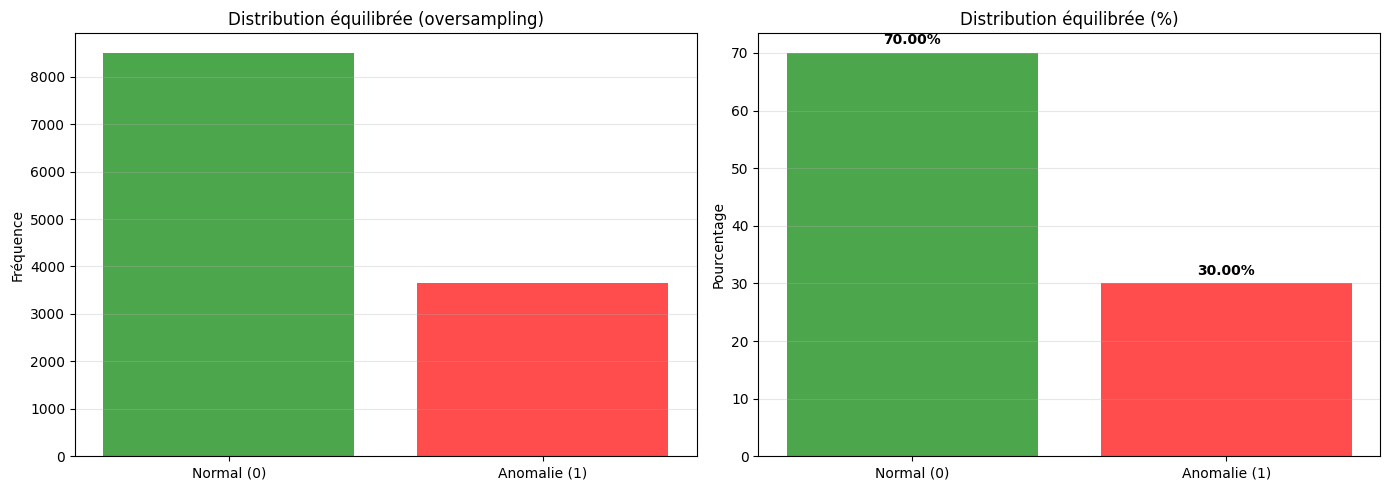

✅ Visualisation équilibrée générée (échantillon oversamplé pour analyse uniquement)
  Total: 12143 lignes | % anomalies ≈ 30.00%


In [7]:
# Paramètre : ratio cible d'anomalies dans l'échantillon visualisé
if "alert_flag" not in df_raw.columns:
    raise ValueError("La colonne alert_flag est requise pour l'équilibrage visuel.")

desired_anomaly_ratio = 0.30  # 30% d'anomalies pour la visualisation
if not 0 < desired_anomaly_ratio < 1:
    raise ValueError("desired_anomaly_ratio doit être entre 0 et 1.")

normal_df = df_raw[df_raw["alert_flag"] == 0]
anomaly_df = df_raw[df_raw["alert_flag"] == 1]

current_ratio = anomaly_df.shape[0] / (anomaly_df.shape[0] + normal_df.shape[0])
print(f"Ratio d'anomalies actuel : {current_ratio*100:.2f}%")

# Calculer le nombre cible d'anomalies pour atteindre desired_anomaly_ratio
neg_count = len(normal_df)
target_pos = int(np.round((desired_anomaly_ratio / (1 - desired_anomaly_ratio)) * neg_count))
target_pos = max(target_pos, 1)

if target_pos <= len(anomaly_df):
    anomaly_balanced = anomaly_df.sample(target_pos, random_state=42)
else:
    additional = target_pos - len(anomaly_df)
    anomaly_extra = anomaly_df.sample(additional, replace=True, random_state=42)
    anomaly_balanced = pd.concat([anomaly_df, anomaly_extra], ignore_index=True)

# Construire l'échantillon équilibré pour visualisation
balanced_viz_df = pd.concat([normal_df, anomaly_balanced], ignore_index=True)
balanced_viz_df = balanced_viz_df.sample(frac=1, random_state=42).reset_index(drop=True)

balanced_counts = balanced_viz_df["alert_flag"].value_counts().sort_index()
balanced_pct = balanced_viz_df["alert_flag"].value_counts(normalize=True).sort_index() * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].bar(['Normal (0)', 'Anomalie (1)'], balanced_counts.values, color=['green', 'red'], alpha=0.7)
axes[0].set_title("Distribution équilibrée (oversampling)")
axes[0].set_ylabel('Fréquence')
axes[0].grid(True, alpha=0.3, axis='y')

axes[1].bar(['Normal (0)', 'Anomalie (1)'], balanced_pct.values, color=['green', 'red'], alpha=0.7)
axes[1].set_title('Distribution équilibrée (%)')
axes[1].set_ylabel('Pourcentage')
axes[1].grid(True, alpha=0.3, axis='y')
for i, val in enumerate(balanced_pct.values):
    axes[1].text(i, val + 1, f'{val:.2f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("✅ Visualisation équilibrée générée (échantillon oversamplé pour analyse uniquement)")
print(f"  Total: {len(balanced_viz_df)} lignes | % anomalies ≈ {balanced_pct.iloc[1]:.2f}%")


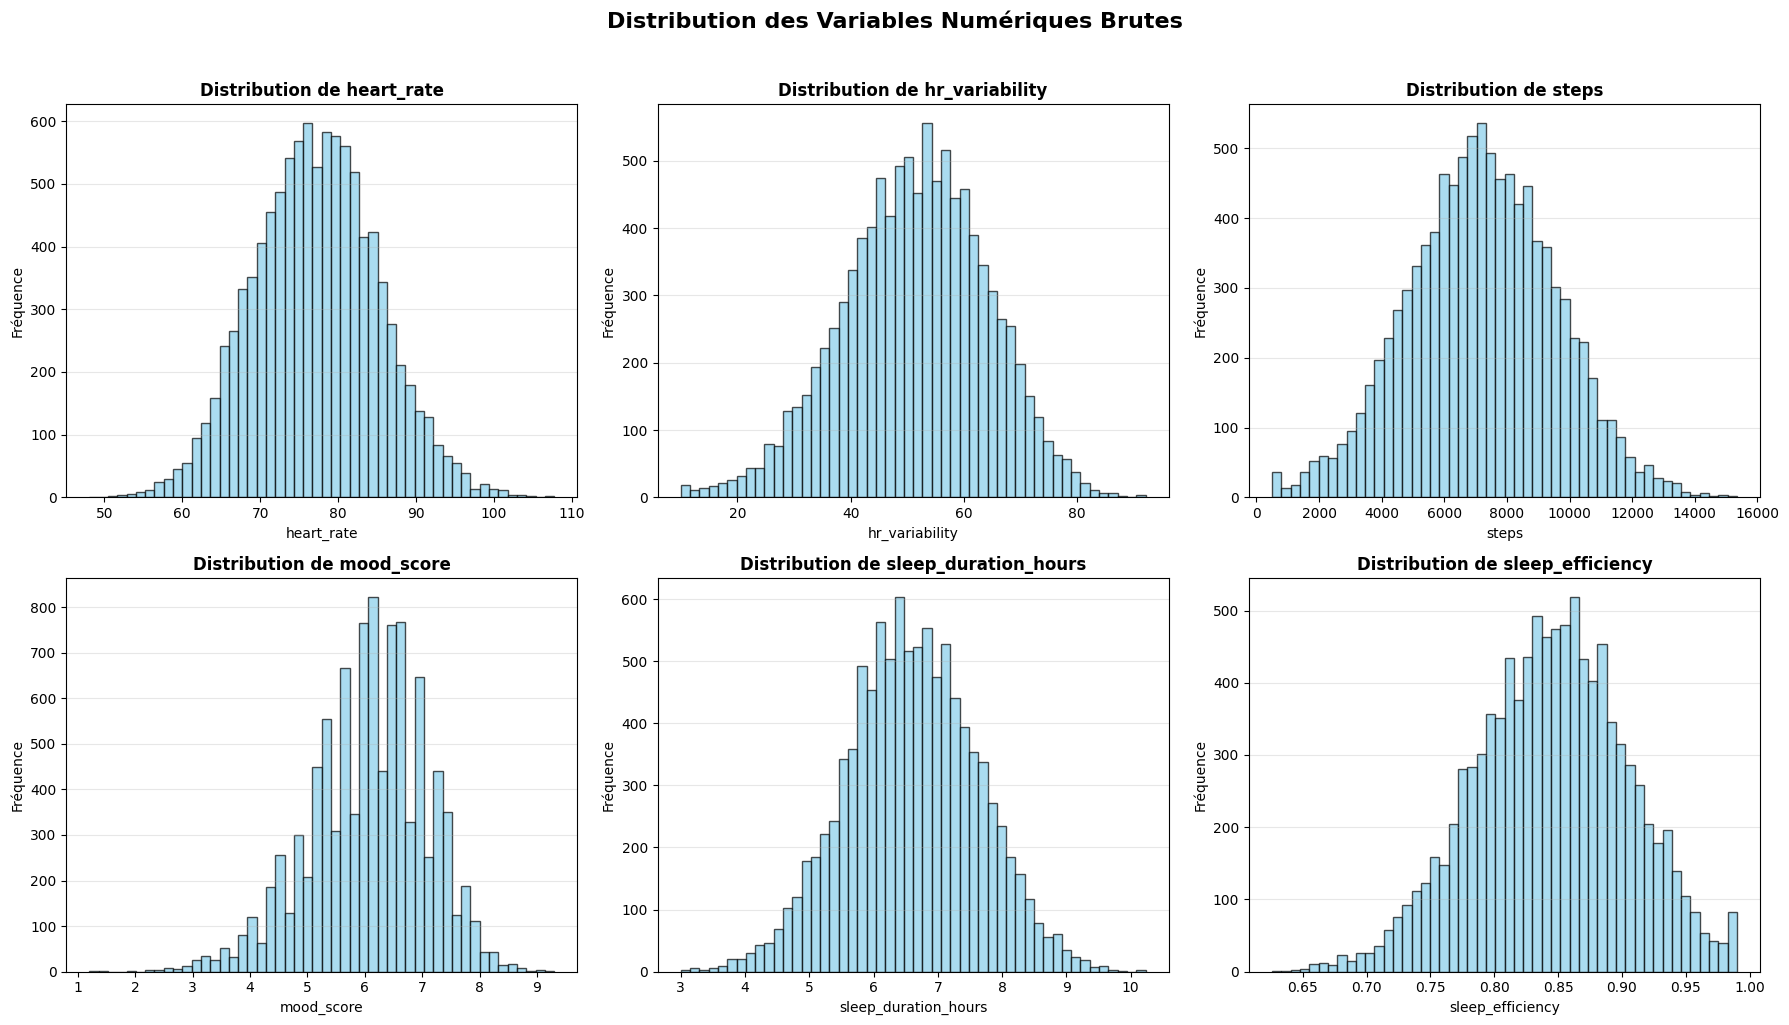


✅ Visualisations des distributions créées pour 6 variables


In [8]:
# Visualisation des variables numériques principales
numeric_cols_raw = df_raw.select_dtypes(include=[np.number]).columns.tolist()
if 'patient_id' in numeric_cols_raw:
    numeric_cols_raw.remove('patient_id')
if 'alert_flag' in numeric_cols_raw:
    numeric_cols_raw.remove('alert_flag')

if len(numeric_cols_raw) > 0:
    # Sélectionner quelques variables importantes
    key_vars = ['heart_rate', 'hr_variability', 'steps', 'mood_score', 
                'sleep_duration_hours', 'sleep_efficiency', 'age']
    key_vars = [v for v in key_vars if v in numeric_cols_raw][:6]
    
    if len(key_vars) > 0:
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        axes = axes.flatten()
        
        for i, var in enumerate(key_vars):
            axes[i].hist(df_raw[var].dropna(), bins=50, edgecolor='black', alpha=0.7, color='skyblue')
            axes[i].set_title(f'Distribution de {var}', fontsize=12, fontweight='bold')
            axes[i].set_xlabel(var)
            axes[i].set_ylabel('Fréquence')
            axes[i].grid(True, alpha=0.3, axis='y')
        
        # Masquer les axes non utilisés
        for i in range(len(key_vars), len(axes)):
            axes[i].axis('off')
        
        plt.suptitle('Distribution des Variables Numériques Brutes', fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()
        
        print(f"\n✅ Visualisations des distributions créées pour {len(key_vars)} variables")


## 3. Feature Engineering Patient-Centric


## 3. Feature Engineering Patient-Centric


In [5]:
def build_features_patient_centric(df: pd.DataFrame, window: int = 7):
    """
    Feature engineering centré patient avec rolling windows.
    Identique à celui utilisé pour l'entraînement.
    """
    df = df.copy()
    
    # Identifier la colonne timestamp
    timestamp_col = None
    for col in ["timestamp", "date"]:
        if col in df.columns:
            timestamp_col = col
            break
    
    if timestamp_col is None:
        raise ValueError("Colonne timestamp/date introuvable")
    
    # Convertir date en datetime si nécessaire
    if timestamp_col == "date" and pd.api.types.is_string_dtype(df[timestamp_col]):
        df[timestamp_col] = pd.to_datetime(df[timestamp_col])
    
    # Trier par patient_id et timestamp
    df = df.sort_values(by=["patient_id", timestamp_col]).reset_index(drop=True)
    
    # Variables continues pour rolling statistics
    continuous_vars = [
        "heart_rate", "hr_variability", "steps", "mood_score",
        "sleep_duration_hours", "sleep_efficiency", "num_awakenings"
    ]
    continuous_vars = [v for v in continuous_vars if v in df.columns]
    
    print(f"Variables continues traitées: {continuous_vars}")
    
    # Calculer rolling mean et std pour chaque variable continue
    for col in continuous_vars:
        roll_mean = df.groupby("patient_id")[col].transform(
            lambda x: x.rolling(window=window, min_periods=3).mean()
        )
        roll_std = df.groupby("patient_id")[col].transform(
            lambda x: x.rolling(window=window, min_periods=3).std()
        )
        df[f"{col}_delta"] = df[col] - roll_mean
        z_score = df[f"{col}_delta"] / (roll_std + 1e-6)
        z_score = z_score.replace([np.inf, -np.inf], np.nan)
        df[f"{col}_z"] = z_score
    
    # Dérivées utiles
    if "steps" in df.columns:
        df["steps_log1p"] = np.log1p(df["steps"])
    
    if "num_awakenings" in df.columns and "sleep_duration_hours" in df.columns:
        df["awakenings_per_hour"] = df["num_awakenings"] / df["sleep_duration_hours"].clip(lower=0.5)
    
    if "day_of_week" in df.columns:
        df["dow_sin"] = np.sin(2 * np.pi * df["day_of_week"] / 7)
        df["dow_cos"] = np.cos(2 * np.pi * df["day_of_week"] / 7)
    
    if "heart_rate" in df.columns and "hr_variability" in df.columns:
        hrv_clipped = df["hr_variability"].clip(lower=1e-3)
        df["hr_hrv_ratio"] = df["heart_rate"] / hrv_clipped
    
    if "sleep_duration_hours" in df.columns:
        df["sleep_debt"] = np.maximum(0, 7.5 - df["sleep_duration_hours"])
    
    # Construire les listes de features
    num_cols = []
    cat_cols = []
    
    for col in continuous_vars:
        if f"{col}_delta" in df.columns:
            num_cols.append(f"{col}_delta")
        if f"{col}_z" in df.columns:
            num_cols.append(f"{col}_z")
    
    if "steps_log1p" in df.columns:
        num_cols.append("steps_log1p")
    if "awakenings_per_hour" in df.columns:
        num_cols.append("awakenings_per_hour")
    if "hr_hrv_ratio" in df.columns:
        num_cols.append("hr_hrv_ratio")
    if "sleep_debt" in df.columns:
        num_cols.append("sleep_debt")
    if "age" in df.columns:
        num_cols.append("age")
    if "dow_sin" in df.columns:
        num_cols.append("dow_sin")
    if "dow_cos" in df.columns:
        num_cols.append("dow_cos")
    
    for col in ["weekend", "medication_taken", "is_female"]:
        if col in df.columns:
            cat_cols.append(col)
    
    num_cols = [col for col in num_cols if col in df.columns]
    cat_cols = [col for col in cat_cols if col in df.columns]
    
    keep_cols = ["patient_id", timestamp_col] + num_cols + cat_cols
    keep_cols = [col for col in keep_cols if col in df.columns]
    df_enrichi = df[keep_cols].copy()
    
    feature_cols = num_cols + cat_cols
    df_enrichi = df_enrichi.dropna(subset=feature_cols)
    
    return df_enrichi, num_cols, cat_cols

print("✅ Fonction build_features_patient_centric définie")


✅ Fonction build_features_patient_centric définie


In [9]:
# Appliquer le feature engineering
print("="*70)
print("FEATURE ENGINEERING PATIENT-CENTRIC")
print("="*70)

df_preprocessed, num_cols, cat_cols = build_features_patient_centric(df_raw, window=window)

print(f"\n✅ Feature engineering terminé!")
print(f"\n📊 Résultats:")
print(f"  Échantillons après feature engineering: {len(df_preprocessed)}")
print(f"  Features numériques: {len(num_cols)}")
print(f"  Features catégorielles: {len(cat_cols)}")
print(f"  Total features: {len(num_cols) + len(cat_cols)}")

print(f"\n📋 Features numériques ({len(num_cols)}):")
for i, col in enumerate(num_cols, 1):
    print(f"  {i:2d}. {col}")

print(f"\n📋 Features catégorielles ({len(cat_cols)}):")
for i, col in enumerate(cat_cols, 1):
    print(f"  {i}. {col}")


FEATURE ENGINEERING PATIENT-CENTRIC
Variables continues traitées: ['heart_rate', 'hr_variability', 'steps', 'mood_score', 'sleep_duration_hours', 'sleep_efficiency', 'num_awakenings']

✅ Feature engineering terminé!

📊 Résultats:
  Échantillons après feature engineering: 9600
  Features numériques: 21
  Features catégorielles: 3
  Total features: 24

📋 Features numériques (21):
   1. heart_rate_delta
   2. heart_rate_z
   3. hr_variability_delta
   4. hr_variability_z
   5. steps_delta
   6. steps_z
   7. mood_score_delta
   8. mood_score_z
   9. sleep_duration_hours_delta
  10. sleep_duration_hours_z
  11. sleep_efficiency_delta
  12. sleep_efficiency_z
  13. num_awakenings_delta
  14. num_awakenings_z
  15. steps_log1p
  16. awakenings_per_hour
  17. hr_hrv_ratio
  18. sleep_debt
  19. age
  20. dow_sin
  21. dow_cos

📋 Features catégorielles (3):
  1. weekend
  2. medication_taken
  3. is_female


## 4. Visualisation des Features Créées


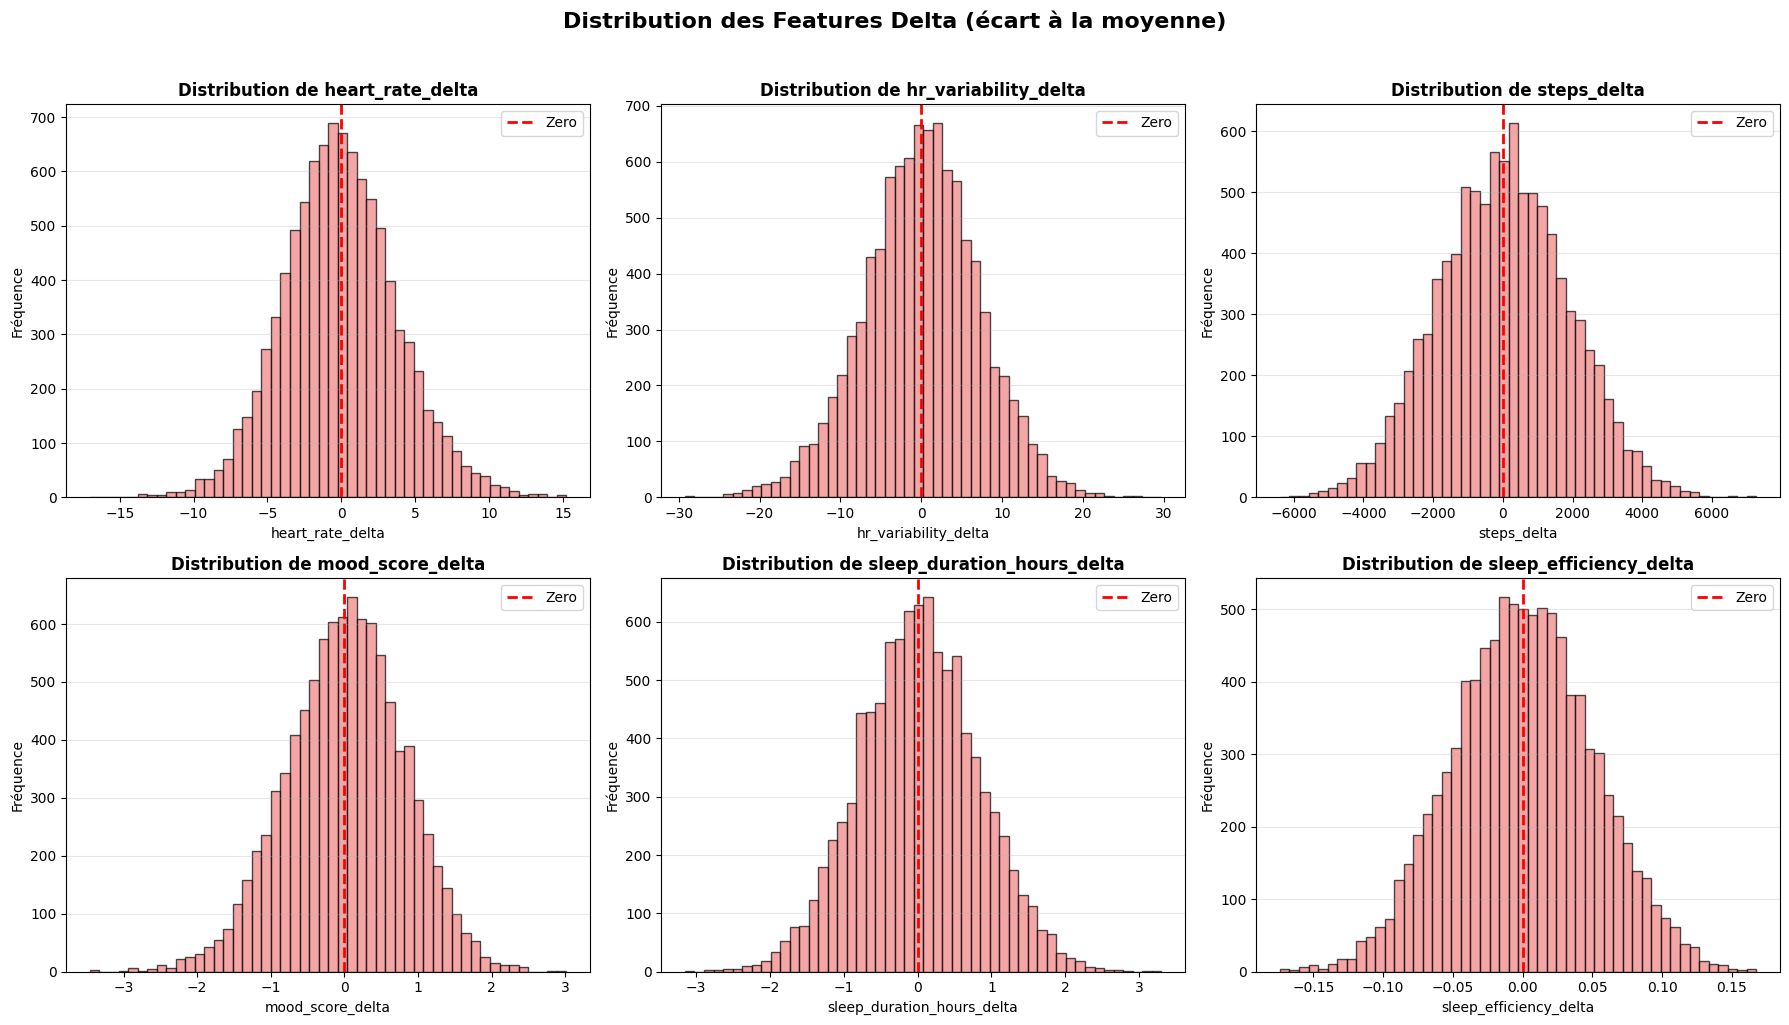

✅ Visualisations des features delta créées


In [9]:
# Visualisation des features delta
delta_cols = [col for col in num_cols if '_delta' in col][:6]

if len(delta_cols) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    for i, var in enumerate(delta_cols[:6]):
        axes[i].hist(df_preprocessed[var].dropna(), bins=50, edgecolor='black', alpha=0.7, color='lightcoral')
        axes[i].set_title(f'Distribution de {var}', fontsize=12, fontweight='bold')
        axes[i].set_xlabel(var)
        axes[i].set_ylabel('Fréquence')
        axes[i].grid(True, alpha=0.3, axis='y')
        axes[i].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero')
        axes[i].legend()
    
    # Masquer les axes non utilisés
    for i in range(len(delta_cols), len(axes)):
        axes[i].axis('off')
    
    plt.suptitle('Distribution des Features Delta (écart à la moyenne)', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    print(f"✅ Visualisations des features delta créées")


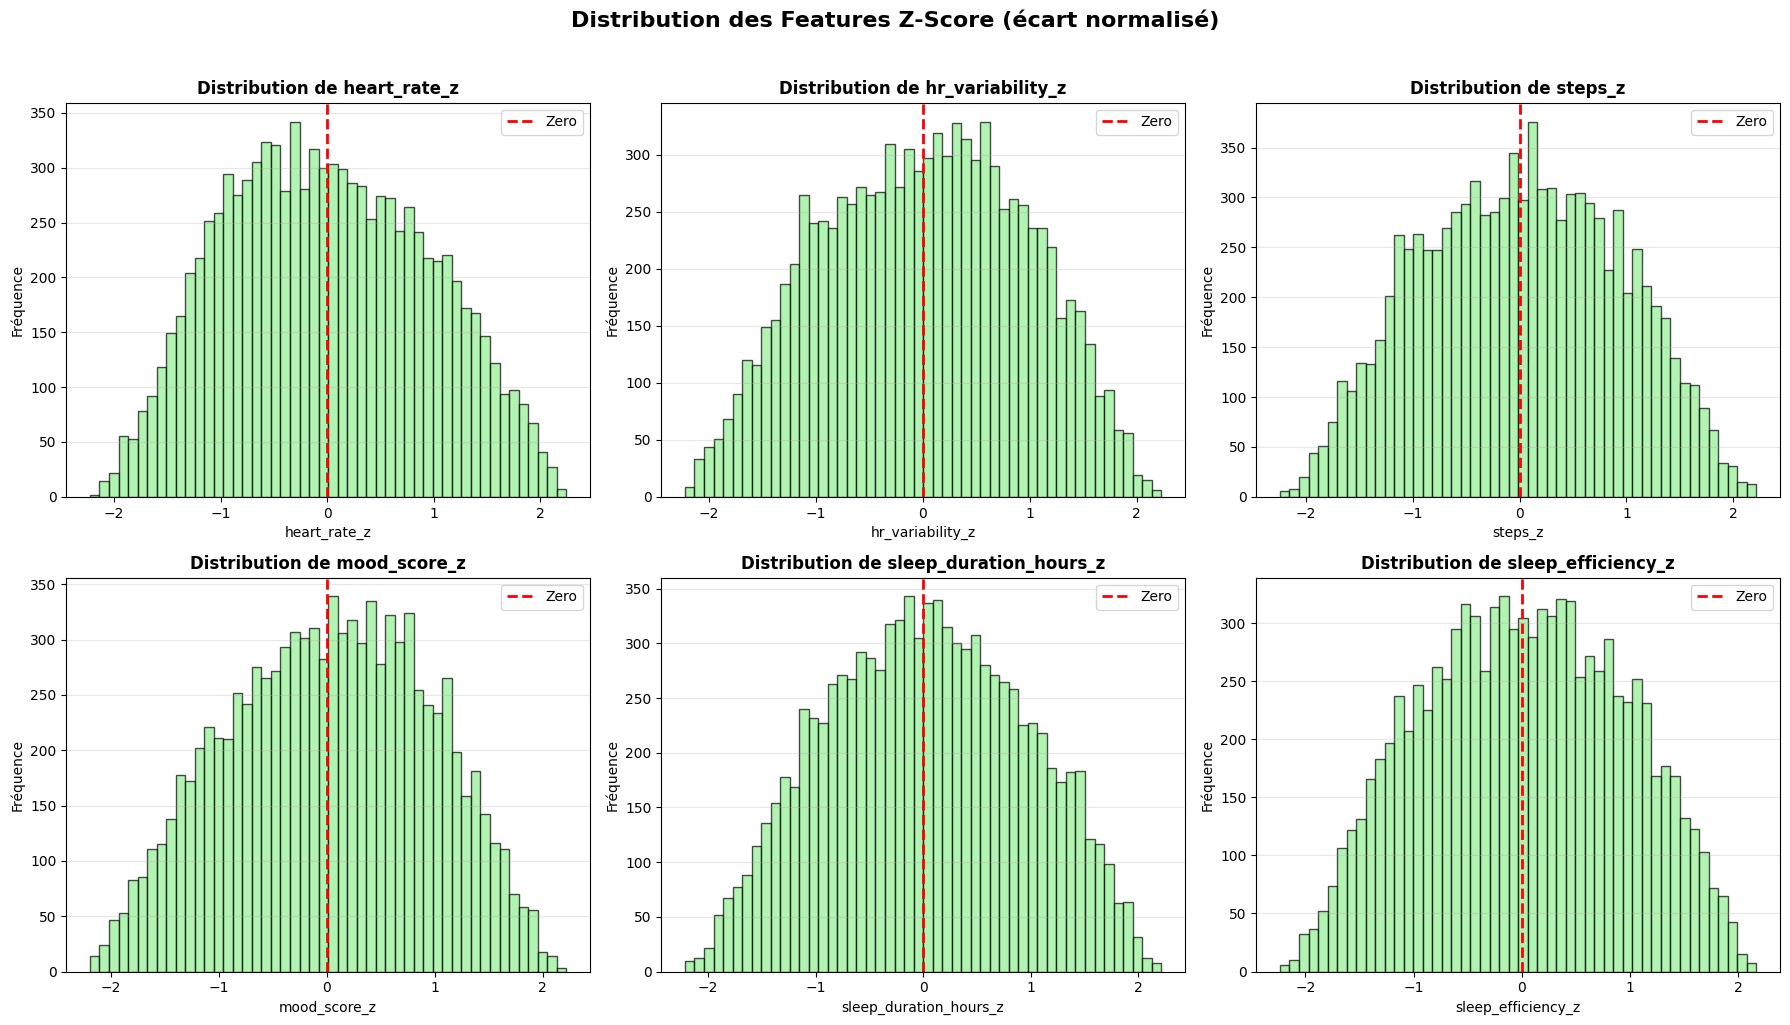

✅ Visualisations des features z-score créées


In [10]:
# Visualisation des features z-score
z_cols = [col for col in num_cols if '_z' in col][:6]

if len(z_cols) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    for i, var in enumerate(z_cols[:6]):
        axes[i].hist(df_preprocessed[var].dropna(), bins=50, edgecolor='black', alpha=0.7, color='lightgreen')
        axes[i].set_title(f'Distribution de {var}', fontsize=12, fontweight='bold')
        axes[i].set_xlabel(var)
        axes[i].set_ylabel('Fréquence')
        axes[i].grid(True, alpha=0.3, axis='y')
        axes[i].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero')
        axes[i].legend()
    
    # Masquer les axes non utilisés
    for i in range(len(z_cols), len(axes)):
        axes[i].axis('off')
    
    plt.suptitle('Distribution des Features Z-Score (écart normalisé)', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    print(f"✅ Visualisations des features z-score créées")


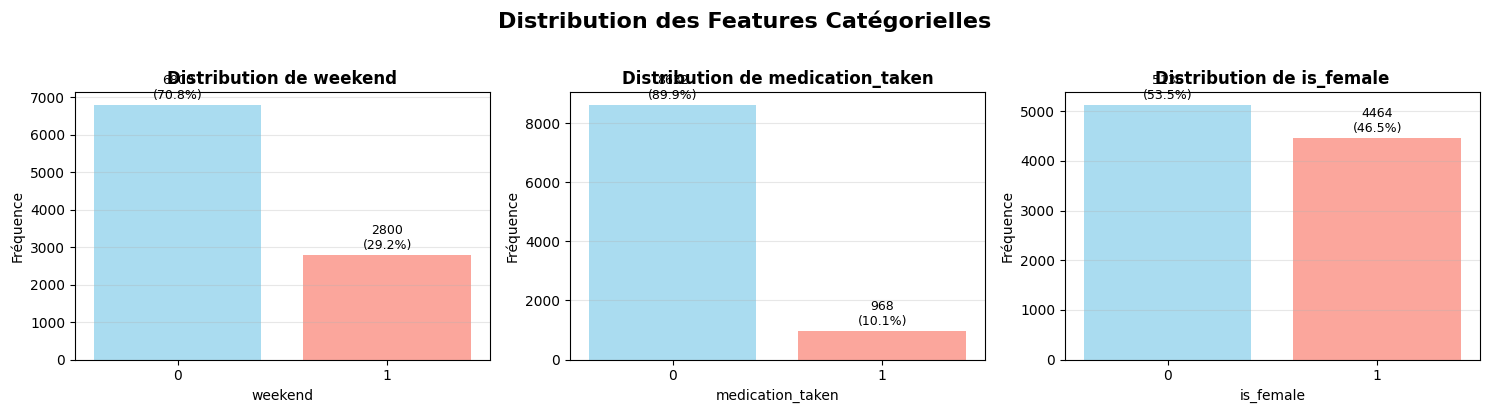

✅ Visualisations des features catégorielles créées


In [10]:
# Visualisation des features catégorielles
if len(cat_cols) > 0:
    fig, axes = plt.subplots(1, len(cat_cols), figsize=(5*len(cat_cols), 4))
    if len(cat_cols) == 1:
        axes = [axes]
    
    for i, col in enumerate(cat_cols):
        value_counts = df_preprocessed[col].value_counts().sort_index()
        axes[i].bar(value_counts.index.astype(str), value_counts.values, 
                   color=['skyblue', 'salmon'][:len(value_counts)], alpha=0.7)
        axes[i].set_title(f'Distribution de {col}', fontsize=12, fontweight='bold')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Fréquence')
        axes[i].grid(True, alpha=0.3, axis='y')
        axes[i].tick_params(axis='x', rotation=0)
        
        # Ajouter les valeurs sur les barres
        for j, (idx, val) in enumerate(value_counts.items()):
            axes[i].text(j, val + max(value_counts.values)*0.01, 
                        f'{val}\n({val/len(df_preprocessed)*100:.1f}%)', 
                        ha='center', va='bottom', fontsize=9)
    
    plt.suptitle('Distribution des Features Catégorielles', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    print(f"✅ Visualisations des features catégorielles créées")


## 5. Vérification des Features


In [11]:
# Vérification des colonnes manquantes
print("="*70)
print("VERIFICATION DES FEATURES")
print("="*70)

missing_cols = []
for col in num_cols + cat_cols:
    if col not in df_preprocessed.columns:
        missing_cols.append(col)

if missing_cols:
    print(f"\n⚠️  Colonnes manquantes: {missing_cols}")
else:
    print(f"\n✅ Toutes les features sont présentes")

# Vérification des valeurs manquantes
feature_cols = num_cols + cat_cols
missing_values = df_preprocessed[feature_cols].isnull().sum().sum()
if missing_values > 0:
    print(f"\n⚠️  {missing_values} valeurs manquantes détectées dans les features")
    print(f"   ℹ️  Ces lignes ont été supprimées automatiquement")
else:
    print(f"\n✅ Aucune valeur manquante dans les features")

# Statistiques descriptives
print(f"\n📊 Statistiques descriptives des features numériques:")
df_preprocessed[num_cols].describe()


VERIFICATION DES FEATURES

✅ Toutes les features sont présentes

✅ Aucune valeur manquante dans les features

📊 Statistiques descriptives des features numériques:


,heart_rate_delta,heart_rate_z,hr_variability_delta,hr_variability_z,steps_delta,steps_z,mood_score_delta,mood_score_z,sleep_duration_hours_delta,sleep_duration_hours_z,...,sleep_efficiency_z,num_awakenings_delta,num_awakenings_z,steps_log1p,awakenings_per_hour,hr_hrv_ratio,sleep_debt,age,dow_sin,dow_cos
count,9600.000000,9600.000000,9600.000000,9600.000000,9600.000000,9600.000000,9600.000000,9600.000000,9600.000000,9600.000000,...,9600.000000,9600.000000,9600.000000,9600.000000,9600.000000,9600.000000,9600.000000,9600.00000,9600.000000,9600.000000
mean,-0.055100,-0.011065,0.065829,0.003658,22.709832,0.008378,0.014263,0.018423,0.018116,0.021085,...,0.007172,-0.002891,-0.000812,8.815093,0.159969,1.657649,1.011004,51.60000,-0.016288,-0.012989
std,3.861788,0.944155,7.153872,0.942688,1859.020558,0.919131,0.798586,0.924967,0.805508,0.920928,...,0.926253,0.941206,0.924341,0.406644,0.165399,0.748389,0.864368,18.34789,0.705315,0.708662
min,-17.014286,-2.227399,-29.225000,-2.222213,-6393.285714,-2.245221,-3.457143,-2.194474,-3.144286,-2.213723,...,-2.233726,-2.500000,-2.267784,6.216606,0.000000,0.673254,0.000000,18.00000,-0.974928,-0.900969
25%,-2.614286,-0.751653,-4.471429,-0.732141,-1246.071429,-0.699596,-0.500000,-0.681539,-0.524643,-0.681509,...,-0.703086,-0.714286,-0.783349,8.637107,0.000000,1.221187,0.210000,36.75000,-0.781831,-0.900969
50%,-0.171429,-0.052764,0.200000,0.032319,30.071429,0.016418,0.028571,0.049530,0.014286,0.018235,...,0.009820,-0.142857,-0.133630,8.881628,0.144300,1.486377,0.910000,51.00000,0.000000,-0.222521
75%,2.371429,0.716262,4.680833,0.724195,1272.000000,0.712419,0.542857,0.729347,0.548571,0.716109,...,0.727720,0.571429,0.705475,9.082507,0.257400,1.856176,1.600000,68.00000,0.781831,0.623490
max,15.214286,2.245060,29.700000,2.229651,7267.428571,2.214918,3.014286,2.219279,3.295000,2.212773,...,2.165492,4.714286,2.267785,9.638480,1.304348,10.010000,4.500000,84.00000,0.974928,1.000000


## 5. Aperçu des Données Préprocessées


## 6. Aperçu des Données Préprocessées


In [13]:
# Afficher les premières lignes des données préprocessées
print("="*70)
print("APERCU DES DONNEES PREPROCESSEES")
print("="*70)

print(f"\n📋 Premières lignes:")
df_preprocessed.head()

print(f"\n📊 Dimensions finales:")
print(f"  Lignes: {len(df_preprocessed)}")
print(f"  Colonnes: {len(df_preprocessed.columns)}")
print(f"  Features pour le modèle: {len(num_cols) + len(cat_cols)}")


APERCU DES DONNEES PREPROCESSEES

📋 Premières lignes:

📊 Dimensions finales:
  Lignes: 9600
  Colonnes: 26
  Features pour le modèle: 24


## 6. Sauvegarde des Données Préprocessées (Optionnel)


## 7. Sauvegarde des Données Préprocessées (Optionnel)


In [14]:
# Sauvegarder les données préprocessées
if output_path:
    print("="*70)
    print("SAUVEGARDE DES DONNEES PREPROCESSEES")
    print("="*70)
    
    df_preprocessed.to_csv(output_path, index=False)
    print(f"\n✅ Données sauvegardées dans {output_path}")
    
    # Vérifier si le fichier existe et afficher sa taille
    if Path(output_path).exists():
        file_size = Path(output_path).stat().st_size / 1024 / 1024
        print(f"   Taille du fichier: {file_size:.2f} MB")
else:
    print("\nℹ️  Sauvegarde non effectuée (output_path non défini)")


SAUVEGARDE DES DONNEES PREPROCESSEES

✅ Données sauvegardées dans ../data/clinical_alerts_preprocessed.csv
   Taille du fichier: 3.57 MB


## 7. Préparation pour l'Utilisation avec le Modèle


## 8. Préparation pour l'Utilisation avec le Modèle


In [15]:
# Préparer les features pour le modèle
print("="*70)
print("PREPARATION POUR LE MODELE")
print("="*70)

# Créer le DataFrame X avec toutes les features nécessaires
X = df_preprocessed[num_cols + cat_cols].copy()

print(f"\n✅ Features préparées pour le modèle:")
print(f"  Shape: {X.shape}")
print(f"  Lignes: {X.shape[0]}")
print(f"  Colonnes: {X.shape[1]}")

print(f"\n📋 Colonnes dans X:")
for i, col in enumerate(X.columns, 1):
    print(f"  {i:2d}. {col}")

print(f"\n💡 Les données sont maintenant prêtes pour l'utilisation avec le modèle!")
print(f"\n📝 Exemple d'utilisation:")
print(f"   from src.preprocessing_supervised import load_supervised_model, predict_with_supervised_model")
print(f"   pipeline = load_supervised_model()")
print(f"   results = predict_with_supervised_model(pipeline, X)")


PREPARATION POUR LE MODELE

✅ Features préparées pour le modèle:
  Shape: (9600, 24)
  Lignes: 9600
  Colonnes: 24

📋 Colonnes dans X:
   1. heart_rate_delta
   2. heart_rate_z
   3. hr_variability_delta
   4. hr_variability_z
   5. steps_delta
   6. steps_z
   7. mood_score_delta
   8. mood_score_z
   9. sleep_duration_hours_delta
  10. sleep_duration_hours_z
  11. sleep_efficiency_delta
  12. sleep_efficiency_z
  13. num_awakenings_delta
  14. num_awakenings_z
  15. steps_log1p
  16. awakenings_per_hour
  17. hr_hrv_ratio
  18. sleep_debt
  19. age
  20. dow_sin
  21. dow_cos
  22. weekend
  23. medication_taken
  24. is_female

💡 Les données sont maintenant prêtes pour l'utilisation avec le modèle!

📝 Exemple d'utilisation:
   from src.preprocessing_supervised import load_supervised_model, predict_with_supervised_model
   pipeline = load_supervised_model()
   results = predict_with_supervised_model(pipeline, X)


## 8. Résumé Final


## 9. Résumé Final


In [16]:
print("="*70)
print("RESUME FINAL")
print("="*70)

print(f"\n✅ Preprocessing terminé avec succès!")
print(f"\n📊 Statistiques:")
print(f"  Données brutes: {len(df_raw)} lignes")
print(f"  Données préprocessées: {len(df_preprocessed)} lignes")
print(f"  Lignes supprimées: {len(df_raw) - len(df_preprocessed)} (valeurs manquantes)")
print(f"  Features créées: {len(num_cols) + len(cat_cols)}")
print(f"    - Numériques: {len(num_cols)}")
print(f"    - Catégorielles: {len(cat_cols)}")

print(f"\n🎯 Prochaines étapes:")
print(f"  1. Charger le modèle: load_supervised_model()")
print(f"  2. Utiliser X pour les prédictions: predict_with_supervised_model(pipeline, X)")

print("\n" + "="*70)


RESUME FINAL

✅ Preprocessing terminé avec succès!

📊 Statistiques:
  Données brutes: 10000 lignes
  Données préprocessées: 9600 lignes
  Lignes supprimées: 400 (valeurs manquantes)
  Features créées: 24
    - Numériques: 21
    - Catégorielles: 3

🎯 Prochaines étapes:
  1. Charger le modèle: load_supervised_model()
  2. Utiliser X pour les prédictions: predict_with_supervised_model(pipeline, X)

